# References used for dataset
https://www.cs.toronto.edu/~kriz/cifar.html


# References used for network architecture
1. https://arxiv.org/abs/1704.06904
2. https://github.com/tengshaofeng/ResidualAttentionNetwork-pytorch/blob/master/Residual-Attention-Network/model/attention_module.py
3. https://github.com/Piyushdharkar/Residual-Attention-Aware-Network
4. https://github.com/deontaepharr/Residual-Attention-Network

# References used for keras functions
1. https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 
2. https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [1]:
import numpy as np
import time
import tensorflow as tf
from matplotlib import pyplot as plt

**Load the CIFAR-10 Dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (50000, 32, 32, 3)

 y_train.shape:  (50000, 1)

 x_test.shape:  (10000, 32, 32, 3)

 y_test.shape:  (10000, 1)


**Visualize the dataset**

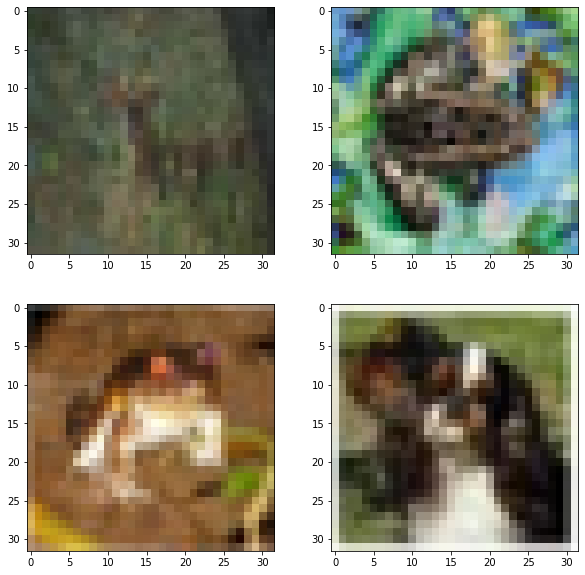

In [4]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))

axes[0, 0].imshow(x_train[10])
axes[0, 1].imshow(x_train[200])
axes[1, 0].imshow(x_train[0])
axes[1, 1].imshow(x_train[500])

In [5]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)

**Divide the data into train, test and validation**

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
np.random.seed(0)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8)

print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_val.shape: ", x_val.shape)
print("\n y_val.shape: ", y_val.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (40000, 32, 32, 3)

 y_train.shape:  (40000, 10)

 x_val.shape:  (10000, 32, 32, 3)

 y_val.shape:  (10000, 10)

 x_test.shape:  (10000, 32, 32, 3)

 y_test.shape:  (10000, 10)


**Creating Residual Block**

In [8]:
from tensorflow.keras import activations

In [9]:
def create_residual_block(val_in, filter_in, filter_out):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @output : Tensor created after residual block
    '''
    
    # Repeat BN=>ReLU=>Conv2D pattern three times
    
    x = tf.keras.layers.BatchNormalization()(val_in)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_in, kernel_size = 1, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 3, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(x)
    
    val_in = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(val_in)
    
    x = tf.keras.layers.Add()([val_in, x])
    
    return x

**Creating Attention Block**

The attention Module consists of mask branch and trunk branch. The trunk branch performs feature selection (using the residual blocks) and the mask branch learns the mask to be applied from downsampling and upsampling. The output of the attention block is (1+M(x)).T(x), where M(x) is the mask and T(x) is the output of the trunk branch (pre-processing).

In [10]:
def create_attention_block(val_in, filter_in, filter_out, p = 1, t = 2, r = 1):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @params p : Number of pre-processing residual units before splitting into trunk and mask branch (is also a hyperparameter)
    @params t : Number of residual units in trunk branch (is also a hyperparameter)
    @params r : Number of residual units between adjacent pooling layer in the mask branch (is also a hyperparameter)
    @output: Tensor created after attention block
    '''
    
    # Creating residual blocks for pre-processing residual units
    for units in range(p):
        val_in = create_residual_block(val_in, filter_in, filter_out)
     
    val_out_trunk = val_in
    
    # Feature Processing for the trunk branch. Input to the trunk branch is the output of the pre-processing residual blocks
    for units in range(t):
        val_out_trunk = create_residual_block(val_out_trunk, filter_in, filter_out)
        
    # 1. Downsample using MaxPool2D
    # 2. 'r' represents the number of residual units between two max pool layers in the mask branch. Implemented using for loop
    # 3. Add skip connection
    # 4. Upsample using UpSampling2D
    
    
    # Down Sampling One
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(val_in)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    
    # Adding Skip Connection
    skip_connection = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Down Sampling Two
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(soft_mask_output)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Up Sampling One
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
        soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
        soft_mask_output = tf.keras.layers.Add()([soft_mask_output, skip_connection])
        
    # Up Sampling Two
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
    
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Activation(activation='sigmoid')(soft_mask_output)
    
    # Output is (1 + M(x))*T(x)
    output = tf.keras.layers.Lambda(lambda x: x + 1)(soft_mask_output)
    output = tf.keras.layers.Multiply()([output, val_out_trunk]) 
    
    for i in range(p):
        output = create_residual_block(output, filter_in, filter_out)

    return output

**Creating the Model**

In [11]:
def create_model(size, classes):
    '''
    @params size : Input tensor siz
    @params classes : Number of output classes
    @output : Returns the model created by attention modules
    '''
    val_in = tf.keras.layers.Input(shape=size)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same')(val_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same')(x)

    x = create_residual_block(val_in=x, filter_in=32, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=32, filter_out=32)

    x = create_residual_block(val_in=x, filter_in=64, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=64, filter_out=64)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_attention_block(val_in=x, filter_in=128, filter_out=128)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)

    x = tf.keras.layers.AveragePooling2D(pool_size=4)(x)
    x = tf.keras.layers.Flatten()(x)

    output = tf.keras.layers.Dense(classes, activation='softmax')(x)


    return tf.keras.models.Model(val_in, output)

**Initialize the Model**

In [12]:
model_cifar_10 = create_model(x_train.shape[1:], 10)

model_cifar_10.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-21 23:34:04.530779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 23:34:04.621044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 23:34:04.621760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 23:34:04.624236: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Train the Model**

In [13]:
def lr_schedule (epoch, lr):
    if epoch == 100:
        lr = 0.1 * lr
        print("\n Reducing learning by factor of 10 at epoch: ", epoch)
    elif epoch == 150:
        lr = 0.1 * lr
        print("\n Reducing learning by factor of 10 at epoch: ", epoch)
    
    return lr

In [14]:
augmented_data_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2, vertical_flip=True, 
                                                           rotation_range=0.15, width_shift_range=0.15, height_shift_range=0.15,
                                                           zoom_range=0.15)

augmented_data_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

flow_data_train = augmented_data_train.flow(x_train, y_train)

flow_data_val = augmented_data_val.flow(x_val, y_val)

In [15]:
tic = time.time()

callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history_cifar_10 = model_cifar_10.fit(flow_data_train, validation_data=flow_data_val, batch_size=64, 
                                        steps_per_epoch=flow_data_train.n // 64, validation_steps=flow_data_val.n // 64, epochs = 160,
                                       callbacks=[callback])

toc = time.time()

Epoch 1/160


2021-12-21 23:34:22.333164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


625/625 [==============================] - 88s 106ms/step - loss: 2.7643 - accuracy: 0.2788 - val_loss: 2.0049 - val_accuracy: 0.2915 - lr: 0.0010
Epoch 2/160
625/625 [==============================] - 64s 103ms/step - loss: 1.8505 - accuracy: 0.3449 - val_loss: 2.7421 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 3/160
625/625 [==============================] - 65s 103ms/step - loss: 1.7355 - accuracy: 0.3710 - val_loss: 2.9145 - val_accuracy: 0.3369 - lr: 0.0010
Epoch 4/160
625/625 [==============================] - 65s 103ms/step - loss: 1.6513 - accuracy: 0.4005 - val_loss: 1.9955 - val_accuracy: 0.3433 - lr: 0.0010
Epoch 5/160
625/625 [==============================] - 65s 104ms/step - loss: 1.5963 - accuracy: 0.4182 - val_loss: 2.0008 - val_accuracy: 0.3391 - lr: 0.0010
Epoch 6/160
625/625 [==============================] - 64s 103ms/step - loss: 1.5988 - accuracy: 0.4234 - val_loss: 1.7176 - val_accuracy: 0.4018 - lr: 0.0010
Epoch 7/160
625/625 [==============================] - 65s

In [16]:
print("\n Time to train CIFAR-10: ", (toc - tic)/60, "mins")


 Time to train CIFAR-10:  168.6749614516894 mins


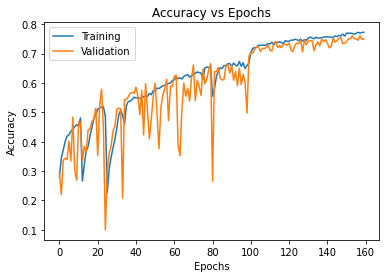

In [19]:
plt.plot(history_cifar_10.history['accuracy'], label = 'Training')
plt.plot(history_cifar_10.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epochs")
plt.legend(loc = 'upper left')

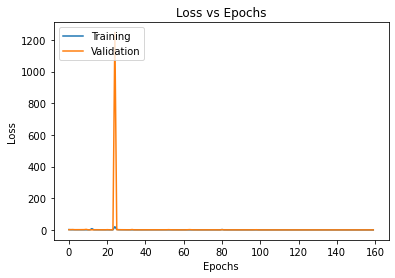

In [20]:
plt.plot(history_cifar_10.history['loss'], label = 'Training')
plt.plot(history_cifar_10.history['val_loss'], label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs Epochs")
plt.legend(loc = 'upper left')

In [18]:
model_cifar_10.save('model_cifar_10.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
